# Start

In [1]:
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product
from typing import Dict, Tuple, List, Any, NamedTuple, Callable
import jax
import jax.numpy as jnp
# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())
from jax import Array
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd
import os
# # Add custom path
sys.path.append("/home/boittier/github/JaxPychamm")
import physnetjax
# MMML
from mmml.pycharmmInterface.import_pycharmm import *
from mmml.pycharmmInterface import setupRes
from physnetjax.analysis.analysis import *
from physnetjax.analysis.povray_tool import *
pycharmm_quiet()

from mmml.generate.dimers import (
    make_rigid_angle_scan, make_rigid_com_scan, make_rotations, get_mean_plane, angle_between_planes, com_dist)
# from mmml.generate.descriptors import com_dist
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def kabsch(P, Q):
    """
    Best-fit alignment of two sets of points using the Kabsch algorithm.
    P and Q should be (N, 3) numpy arrays.
    Returns rotated P, and the rotation matrix R.
    """
    # Center the point clouds
    P_centered = P - np.mean(P, axis=0)
    Q_centered = Q - np.mean(Q, axis=0)
    
    # Covariance matrix
    H = P_centered.T @ Q_centered
    
    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    # Ensure right-handed coordinate system
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Apply rotation to P
    P_aligned = P_centered @ R
    return P_aligned, R
    
def reorder_points(P, Q):
    """
    Match points from Q to P using the Hungarian algorithm.
    Returns Q reordered to best match P.
    """
    distance_matrix = cdist(P, Q)  # shape (N, N)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    return Q[col_ind], col_ind



from mmml.generate.dimers import separate_monomers_by_distance
# Optional: align (should be almost identity if just shuffled)
from numpy.linalg import norm


def reorder_atoms(atoms, A):
    res = separate_monomers_by_distance(atoms)
    monomers = []
    if len(res) == 2:
        monoA_, monoB_ = res
        Z = A.get_atomic_numbers()
        
        for monoA in [monoA_, monoB_]:
            Za = monoA.get_atomic_numbers()
            P = np.array([[z, *xyz] for z, xyz in zip(Z, A.get_positions())])
            Q = np.array([[z, *xyz] for z, xyz in zip(Za, monoA.get_positions())])
            Q_reordered, indices = reorder_points(P - P.mean(axis=0), Q - Q.mean(axis=0))
            aligned_Q, R = kabsch(Q_reordered[indices], P)
            print("Post-alignment RMSD:", np.sqrt(np.mean(np.sum((aligned_Q - (P - P.mean(0)))**2, axis=1))))
            print( Za[indices] == Z, Za[indices], Z)
            Za = Za[indices]
            condition = Za == Z 
            if condition.all():             
                rA = ase.Atoms(Za, Q_reordered[:,1:])
                monomers.append(rA)
    if len(monomers) == 2:
        return monomers[0] + monomers[1]
    # view_atoms(res)



[CudaDevice(id=0), CudaDevice(id=1)]
gpu
[CudaDevice(id=0), CudaDevice(id=1)]
/home/boittier/mmml/mmml/data/top_all36_cgenff.rtf
/home/boittier/mmml/mmml/data/par_all36_cgenff.prm
CHARMM_HOME /home/boittier/mmml/setup/charmm
CHARMM_LIB_DIR /home/boittier/mmml/setup/charmm
  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of 

In [2]:
resid = "MPRO"
reset_block()
res_atoms = setupRes.main(resid)
reset_block()
res_atoms = setupRes.main(resid)
N_atoms_monomer = len(res_atoms)

***** Generating residue from residue name (MPRO) *****
***** Generating residue *****

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
***** Generating coordinates *****

          COORDINATE FILE MODULE
        14  EXT
positions:
         1         1  MPRO      C1           9999.0000000000     9999.0000000000     9999.0000000000  MPRO      1               0.0000000000
         2         1  MPRO      C            9999.0000000000     9999.0000000000     9999.0000000000  MPRO      1               0.0000000000
         3         1  MPRO      OM           9999.0000000000     9999.0000000000     9999.0000000000  MPRO      1               0.0000000000
         4         1  MPRO      C2           9999.0000000000     9999.0000000000     9999.0000000000  MPRO      1               0.0000000000
         5         1  MPRO      O            9999.0000000000  

In [3]:
pycharmm_loud()
energy.show()

  
 CHARMM>    WRNLev 9
  

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are       56 atom  pairs and       55 atom  exclusions.
 There are        0 group pairs and        1 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR      147 ATOM PAIRS AND        0 GROUP PAIRS
 NBONDS: Using routine NBONDA for list generation.

 General atom nonbond list generation found:
       56 ATOM PAIRS WERE FOUND FOR ATOM LIST
        0 GROUP PAIRS REQUIRED ATOM SEARCHES


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  

In [4]:
view_pycharmm_state()

In [5]:
print(N_atoms_monomer)

14


In [6]:
"""Generates a residue from the RTF file"""
print("*" * 5, "Generating residue", "*" * 5)
s = """DELETE ATOM SELE ALL END"""
pycharmm.lingo.charmm_script(s)
read.rtf(CGENFF_RTF)
bl = settings.set_bomb_level(-2)
wl = settings.set_warn_level(-2)
read.prm(CGENFF_PRM)
settings.set_bomb_level(bl)
settings.set_warn_level(wl)
pycharmm.lingo.charmm_script("bomlev 0")
read.sequence_string(f"{resid} {resid}")
gen.new_segment(seg_name="DIMI", setup_ic=True)
R = np.concatenate(
    [res_atoms.get_positions() , (res_atoms.get_positions() + np.array([6,6,6]))]
)
_ = coor.get_positions()
_["x"] = R[:,0]
_["y"] = R[:,1]
_["z"] = R[:,2]
coor.set_positions(_)
reset_block()
setupRes.mini(nbxmod=1)
setupRes.mini(nbxmod=5)


***** Generating residue *****
  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     14 atoms have been selected out of     14

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          1 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:        13 bonds deleted
 DELTIC:        22 angles deleted
 DELTIC:        20 dihedrals deleted
 DELTIC:         1 improper dihedrals deleted
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         Number of dihedrals     =        0   Number of impropers  =        0
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        0   Number of HB donors  =   

In [7]:
view_pycharmm_state()

In [8]:
state_atoms = ase_from_pycharmm_state()
A = state_atoms[:N_atoms_monomer]
B = state_atoms[N_atoms_monomer:]
A,B

(Atoms(symbols='C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3', pbc=False))

In [9]:
view_atoms(A)

In [10]:
view_atoms(B)

In [14]:
fn = "test.xyz"
ase.io.write(fn, A)

In [15]:
test_pos = np.array([A.get_positions(), A.get_positions()]).reshape(-1,3)
test_Z = np.array([A.get_atomic_numbers(), A.get_atomic_numbers()]).reshape(-1)
test_pos 

array([[ 0.5071808 ,  0.34778481,  1.61816312],
       [ 0.79473397, -0.9289501 ,  0.80551227],
       [ 1.6182122 , -0.77756125, -0.24882704],
       [ 2.27277425,  0.45584602, -0.5639033 ],
       [ 0.29483698, -1.9957362 ,  1.11231506],
       [ 0.24063601, -0.01716775,  2.63600916],
       [ 1.40596157,  0.97261347,  1.74783851],
       [ 1.54475621,  1.28118807, -0.7146457 ],
       [ 3.00081541,  0.73148059,  0.23037431],
       [ 2.84243555,  0.33512388, -1.51214039],
       [-0.69442226,  1.16362875,  1.08061682],
       [-0.90063177,  2.03299952,  1.74170521],
       [-1.60776546,  0.52841717,  1.05221861],
       [-0.50423429,  1.54103089,  0.0545523 ],
       [ 0.5071808 ,  0.34778481,  1.61816312],
       [ 0.79473397, -0.9289501 ,  0.80551227],
       [ 1.6182122 , -0.77756125, -0.24882704],
       [ 2.27277425,  0.45584602, -0.5639033 ],
       [ 0.29483698, -1.9957362 ,  1.11231506],
       [ 0.24063601, -0.01716775,  2.63600916],
       [ 1.40596157,  0.97261347,  1.747

In [59]:
# test_pos[15:] = test_pos.mean(axis=0) + 10
# test_pos

In [60]:
_ = ase.Atoms(test_Z.flatten(), test_pos)
view_atoms(_)

In [61]:
from mmml.generate.dimers import generate_from_crystal_syms, make_rotations

min_confs = generate_from_crystal_syms(fn)

In [62]:
min_confs.keys()

dict_keys(['C1', 'Ci', 'C2', 'Cs'])

In [63]:
[len(min_confs[k]) for k in min_confs.keys()]

[20, 7, 19, 2]

In [64]:
all_atoms = make_rotations(A, B, distance = 8, n_monomer_a=N_atoms_monomer)

In [65]:
len(all_atoms)

450

In [66]:
view_atoms(all_atoms[0])

In [67]:
refA = state_atoms[:N_atoms_monomer]
refB = state_atoms[N_atoms_monomer:]
n_failed = 0
for k in min_confs.keys():
    for _ in min_confs[k]:
        try:
            _ = reorder_atoms(_[0], refA)
            if _ is not None:
                set_pycharmm_xyz(_.get_positions())
                # setupRes.mini()
                _.set_positions(coor.get_positions().to_numpy())
                
                _R = _.get_positions()
                _R += ((np.random.normal(size=np.prod(_R.shape)).reshape(_R.shape))*0.01)
                _.set_positions(_R)
                A = _[:N_atoms_monomer]
                B = _[N_atoms_monomer:]
                for rotated in make_rotations(A, B, distance = 8, n_monomer_a=N_atoms_monomer):
                    all_atoms.append(rotated)
        except ValueError as valEr:
            print(valEr)
            print(k, n_failed)
            n_failed += 1

Post-alignment RMSD: 4.900203177454137
[ True  True  True  True False  True  True  True  True  True False  True
  True  True] [6 6 8 6 6 1 1 1 1 1 8 1 1 1] [6 6 8 6 8 1 1 1 1 1 6 1 1 1]
Post-alignment RMSD: 5.066009058792449
[ True  True  True  True False  True  True  True  True  True False  True
  True  True] [6 6 8 6 6 1 1 1 1 1 8 1 1 1] [6 6 8 6 8 1 1 1 1 1 6 1 1 1]
Post-alignment RMSD: 4.681641435831278
[False  True False  True  True  True  True  True  True  True  True  True
  True  True] [8 6 6 6 8 1 1 1 1 1 6 1 1 1] [6 6 8 6 8 1 1 1 1 1 6 1 1 1]
Post-alignment RMSD: 4.013240601020157
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True] [6 6 8 6 8 1 1 1 1 1 6 1 1 1] [6 6 8 6 8 1 1 1 1 1 6 1 1 1]
Post-alignment RMSD: 4.19322244207994
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True] [6 6 8 6 8 1 1 1 1 1 6 1 1 1] [6 6 8 6 8 1 1 1 1 1 6 1 1 1]
Post-alignment RMSD: 4.024288080649566
[ True  True  True  True  True  

In [68]:
# pycharmm_loud()
pycharmm_quiet()

  
 CHARMM>     PRNLev 0


In [69]:
all_atoms_data = []
for _ in all_atoms:
    set_pycharmm_xyz(_.get_positions())

    setupRes.mini(nbxmod=1)
    setupRes.mini(nbxmod=5)
    energy.show()
    
    _data = energy.get_energy().to_dict()
    _data = {x:_data[x][0] for x in _data}

    c1,n1 = get_mean_plane(_[:N_atoms_monomer])
    c2,n2 = get_mean_plane(_[N_atoms_monomer:])
    theta1 = angle_between_planes(n1, n2)
    theta2 = angle_between_planes(c1, c2)
    com_r = com_dist(_,N_atoms_monomer)
    _data.update(
        {"$\\theta_1$": theta1,
         "$\\theta_2$": theta2,
         "$r$": com_r}
    )
    all_atoms_data.append(_data)

***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minimizing *****
***** Minim

In [70]:
_data

{'ENER': 36.0565698719431,
 'GRMS': 0.5755830649602178,
 'DELTA': -0.019919348152811267,
 'BOND': 0.23714546043093396,
 'ANGL': 1.416345895376023,
 'UREY': 0.2308832816429289,
 'DIHE': -0.5315049174466334,
 'IMPR': 0.0027176906013432053,
 'VDW': -0.20811185291709178,
 'ELEC': 34.90909431425559,
 'HBON': 0.0,
 'USER': 0.0,
 'HARM': 0.0,
 'CDIH': 0.0,
 'CIC': 0.0,
 'CDRO': 0.0,
 'NOE': 0.0,
 'SBOU': 0.0,
 'IMNB': 0.0,
 'IMEL': 0.0,
 'IMHB': 0.0,
 'EWKS': 0.0,
 'EWSE': 0.0,
 'EXTE': 0.0,
 'RXNF': 0.0,
 'ST2': 0.0,
 'IMST': 0.0,
 'TSM': 0.0,
 'QMEL': 0.0,
 'QMVD': 0.0,
 'ASP': 0.0,
 'EHAR': 0.0,
 'GEO': 0.0,
 'MDIP': 0.0,
 'PINT': 0.0,
 'PRMS': 0.0,
 'PANG': 0.0,
 'SSBP': 0.0,
 'BK4D': 0.0,
 'SHEL': 0.0,
 'RESD': 0.0,
 'SHAP': 0.0,
 'STRB': 0.0,
 'OOPL': 0.0,
 'PULL': 0.0,
 'POLA': 0.0,
 'DMC': 0.0,
 'RGY': 0.0,
 'EWEX': 0.0,
 'EWQC': 0.0,
 'EWUT': 0.0,
 'PBEL': 0.0,
 'PBNP': 0.0,
 'MBDE': 0.0,
 'STRS': 0.0,
 'BNDB': 0.0,
 'BNDT': 0.0,
 'EBST': 0.0,
 'MBST': 0.0,
 'BBT': 0.0,
 'SST': 0.0,


In [137]:
_ = pd.DataFrame(all_atoms_data)
_["NBOND"] = _ ["VDW"] + _["ELEC"]
_.keys()

Index(['ENER', 'GRMS', 'DELTA', 'BOND', 'ANGL', 'UREY', 'DIHE', 'IMPR', 'VDW',
       'ELEC', 'HBON', 'USER', 'HARM', 'CDIH', 'CIC', 'CDRO', 'NOE', 'SBOU',
       'IMNB', 'IMEL', 'IMHB', 'EWKS', 'EWSE', 'EXTE', 'RXNF', 'ST2', 'IMST',
       'TSM', 'QMEL', 'QMVD', 'ASP', 'EHAR', 'GEO', 'MDIP', 'PINT', 'PRMS',
       'PANG', 'SSBP', 'BK4D', 'SHEL', 'RESD', 'SHAP', 'STRB', 'OOPL', 'PULL',
       'POLA', 'DMC', 'RGY', 'EWEX', 'EWQC', 'EWUT', 'PBEL', 'PBNP', 'MBDE',
       'STRS', 'BNDB', 'BNDT', 'EBST', 'MBST', 'BBT', 'SST', 'GBEN', 'HMCM',
       '$\theta_1$', '$\theta_2$', '$r$', 'NBOND'],
      dtype='object')

In [138]:
_

,ENER,GRMS,DELTA,BOND,ANGL,UREY,DIHE,IMPR,VDW,ELEC,...,EBST,MBST,BBT,SST,GBEN,HMCM,$\theta_1$,$\theta_2$,$r$,NBOND
0,35.983043,0.575583,0.053608,0.254189,1.290617,0.211171,-0.594464,0.000541,-0.219236,35.040226,...,0.0,0.0,0.0,0.0,0.0,0.0,2.491037,60.277894,8.01,34.820989
1,35.797103,0.575583,0.239547,0.264127,1.320056,0.208475,-0.596835,0.000044,-0.277993,34.879229,...,0.0,0.0,0.0,0.0,0.0,0.0,173.307350,60.709836,8.01,34.601237
2,163.250494,0.575583,-127.213843,5.366874,100.838218,29.157456,1.751569,0.010461,1.365218,24.760699,...,0.0,0.0,0.0,0.0,0.0,0.0,166.632375,61.244101,8.01,26.125917
3,35.833221,0.575583,0.203430,0.260135,1.336631,0.215100,-0.592825,0.000036,-0.225618,34.839761,...,0.0,0.0,0.0,0.0,0.0,0.0,19.656766,61.789300,8.01,34.614143
4,36.059439,0.575583,-0.022789,0.205971,1.409271,0.223682,-0.519035,0.006310,-0.093090,34.826331,...,0.0,0.0,0.0,0.0,0.0,0.0,154.827480,62.250473,8.01,34.733240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12145,99.544349,0.575583,-63.507699,2.838177,50.976552,14.556388,0.664488,0.003662,0.584142,29.920940,...,0.0,0.0,0.0,0.0,0.0,0.0,59.334458,86.257370,7.99,30.505082
12146,35.855298,0.575583,0.181353,0.243118,1.372086,0.216079,-0.586089,0.001109,-0.231290,34.840285,...,0.0,0.0,0.0,0.0,0.0,0.0,47.334471,86.311663,7.99,34.608995
12147,35.876578,0.575583,0.160072,0.251667,1.346114,0.225839,-0.571700,0.001422,-0.286742,34.909978,...,0.0,0.0,0.0,0.0,0.0,0.0,144.665516,86.357823,7.99,34.623236
12148,39.072144,0.575583,-3.035493,0.311665,1.605209,0.244392,2.503447,0.006260,0.176230,34.224942,...,0.0,0.0,0.0,0.0,0.0,0.0,156.665503,86.393826,7.99,34.401171


In [139]:
_ = _[_["ENER"] < 38]

In [140]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]]

,$\theta_1$,$\theta_2$,$r$,VDW,ELEC,NBOND
0,2.491037,60.277894,8.01,-0.219236,35.040226,34.820989
1,173.307350,60.709836,8.01,-0.277993,34.879229,34.601237
3,19.656766,61.789300,8.01,-0.225618,34.839761,34.614143
4,154.827480,62.250473,8.01,-0.093090,34.826331,34.733240
5,150.362433,62.545870,8.01,-0.209564,34.795396,34.585832
...,...,...,...,...,...,...
12143,83.334428,86.134291,7.99,-0.050936,35.069260,35.018324
12144,71.334444,86.197353,7.99,-0.249062,34.912286,34.663223
12146,47.334471,86.311663,7.99,-0.231290,34.840285,34.608995
12147,144.665516,86.357823,7.99,-0.286742,34.909978,34.623236


array([[<Axes: title={'center': '$\\theta_1$'}>,
        <Axes: title={'center': '$\\theta_2$'}>],
       [<Axes: title={'center': '$r$'}>, <Axes: title={'center': 'VDW'}>],
       [<Axes: title={'center': 'ELEC'}>,
        <Axes: title={'center': 'NBOND'}>]], dtype=object)

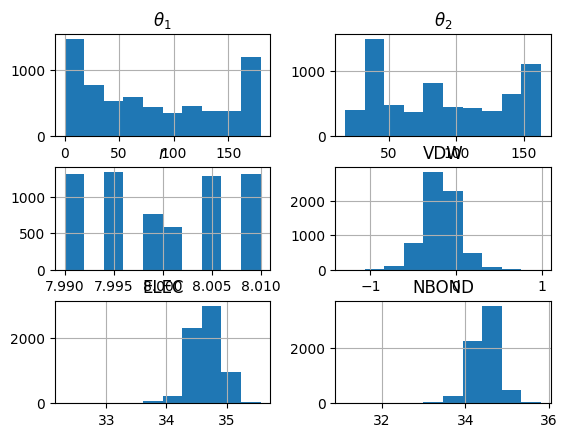

In [141]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]].hist()

In [142]:
_[["$\\theta_1$", "$\\theta_2$", "$r$", "VDW", "ELEC","NBOND"]].describe()

,$\theta_1$,$\theta_2$,$r$,VDW,ELEC,NBOND
count,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000
mean,80.874478,90.627413,7.999955,-0.179207,34.650817,34.471610
std,63.025212,45.197396,0.007053,0.205267,0.267254,0.348856
min,0.111468,17.866296,7.990000,-1.295697,32.309380,31.114326
25%,22.278282,46.149030,7.995000,-0.297971,34.498316,34.298093
50%,70.345017,83.037904,8.000000,-0.181099,34.661018,34.490077
75%,141.663978,140.171978,8.005000,-0.058915,34.834849,34.683304
max,179.833410,162.610217,8.010000,0.993029,35.563828,35.818122


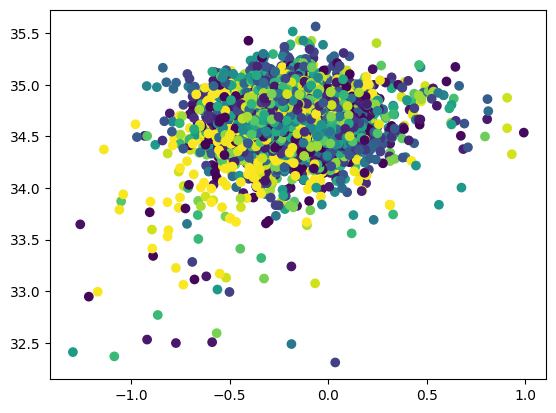

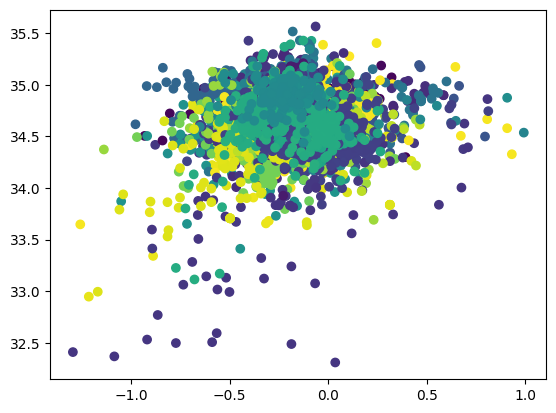

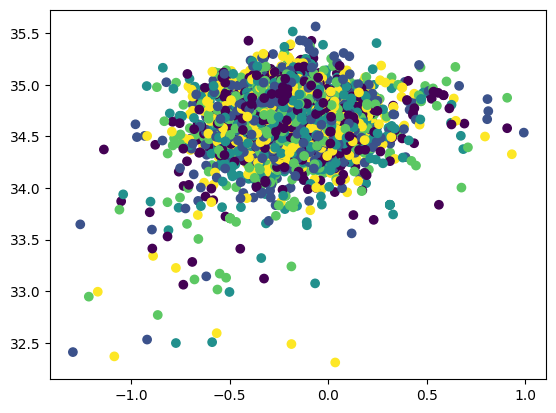

In [143]:
for k in ["$\\theta_1$", "$\\theta_2$", "$r$",]:
    plt.scatter(_ ["VDW"], _["ELEC"], c=_[k])
    plt.show()

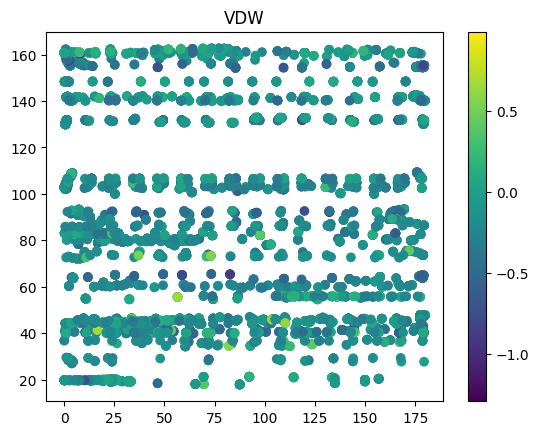

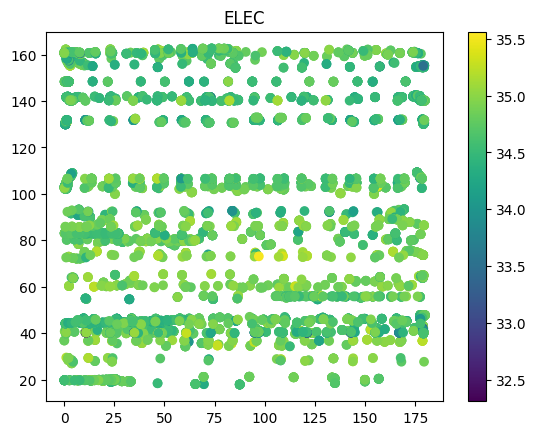

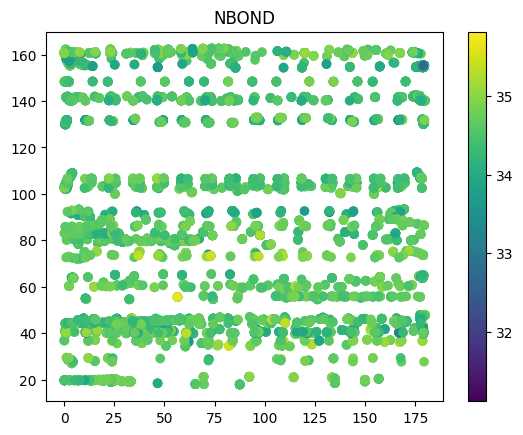

In [144]:
for k in ["VDW", "ELEC", "NBOND"]:
    s = plt.scatter(_ ["$\\theta_1$"],_["$\\theta_2$"], c=_[k])
    plt.colorbar(s)
    plt.title(k)
    plt.show()

In [145]:
_

,ENER,GRMS,DELTA,BOND,ANGL,UREY,DIHE,IMPR,VDW,ELEC,...,EBST,MBST,BBT,SST,GBEN,HMCM,$\theta_1$,$\theta_2$,$r$,NBOND
0,35.983043,0.575583,0.053608,0.254189,1.290617,0.211171,-0.594464,0.000541,-0.219236,35.040226,...,0.0,0.0,0.0,0.0,0.0,0.0,2.491037,60.277894,8.01,34.820989
1,35.797103,0.575583,0.239547,0.264127,1.320056,0.208475,-0.596835,0.000044,-0.277993,34.879229,...,0.0,0.0,0.0,0.0,0.0,0.0,173.307350,60.709836,8.01,34.601237
3,35.833221,0.575583,0.203430,0.260135,1.336631,0.215100,-0.592825,0.000036,-0.225618,34.839761,...,0.0,0.0,0.0,0.0,0.0,0.0,19.656766,61.789300,8.01,34.614143
4,36.059439,0.575583,-0.022789,0.205971,1.409271,0.223682,-0.519035,0.006310,-0.093090,34.826331,...,0.0,0.0,0.0,0.0,0.0,0.0,154.827480,62.250473,8.01,34.733240
5,35.878764,0.575583,0.157887,0.241616,1.344100,0.226315,-0.519843,0.000743,-0.209564,34.795396,...,0.0,0.0,0.0,0.0,0.0,0.0,150.362433,62.545870,8.01,34.585832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12143,36.262927,0.575583,-0.226277,0.265146,1.147230,0.193138,-0.392095,0.031184,-0.050936,35.069260,...,0.0,0.0,0.0,0.0,0.0,0.0,83.334428,86.134291,7.99,35.018324
12144,35.833515,0.575583,0.203136,0.255151,1.300581,0.204461,-0.590534,0.000633,-0.249062,34.912286,...,0.0,0.0,0.0,0.0,0.0,0.0,71.334444,86.197353,7.99,34.663223
12146,35.855298,0.575583,0.181353,0.243118,1.372086,0.216079,-0.586089,0.001109,-0.231290,34.840285,...,0.0,0.0,0.0,0.0,0.0,0.0,47.334471,86.311663,7.99,34.608995
12147,35.876578,0.575583,0.160072,0.251667,1.346114,0.225839,-0.571700,0.001422,-0.286742,34.909978,...,0.0,0.0,0.0,0.0,0.0,0.0,144.665516,86.357823,7.99,34.623236


In [146]:
selected = [all_atoms[i] for i in _.index]
selected

[Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCOH5CH3', pbc=False),
 Atoms(symbols='C2OCOH5CH3C2OCO

In [147]:
# Write them all to a single XYZ file as a trajectory
ase.io.write('trajectory.xyz', selected )

In [148]:
_.to_csv("trajectory.csv")

In [149]:
ase.io.write('trajectory.traj', selected)

In [22]:
import ase
test_traj = ase.io.read("trajectory.traj", index=":")
view_atoms(test_traj[0])

In [23]:
from xtb_ase import XTB

energies = []
forces = []

for atoms in test_traj:
    atoms.calc = XTB()
    energies.append(atoms.get_potential_energy())
    forces.append(atoms.get_forces())


normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
normal termination of xtb
Note: The followin

In [24]:
len(energies)

6605

In [25]:
np.savez("energies", energies)

In [26]:
np.savez("forces", forces)

(array([1.833e+03, 3.425e+03, 1.200e+03, 5.100e+01, 4.400e+01, 3.200e+01,
        1.700e+01, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([-1130.84179414, -1130.73639728, -1130.63100041, -1130.52560355,
        -1130.42020669, -1130.31480982, -1130.20941296, -1130.10401609,
        -1129.99861923, -1129.89322236, -1129.7878255 ]),
 <BarContainer object of 10 artists>)

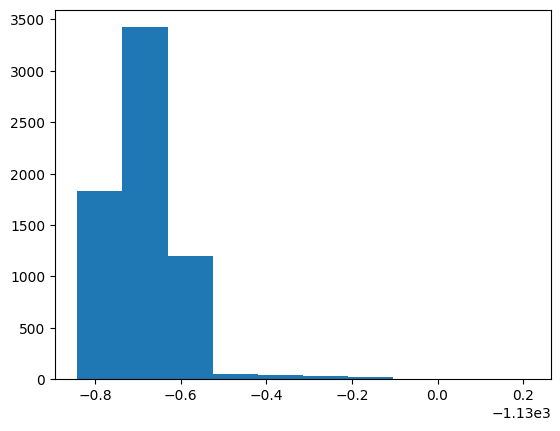

In [28]:
plt.hist(energies)

(array([   395.,   1903.,   5097.,  32056., 158602., 252288.,  88551.,
         11877.,   2966.,   1085.]),
 array([-3.59298335, -2.91320334, -2.23342332, -1.55364331, -0.87386329,
        -0.19408328,  0.48569674,  1.16547675,  1.84525677,  2.52503678,
         3.2048168 ]),
 <BarContainer object of 10 artists>)

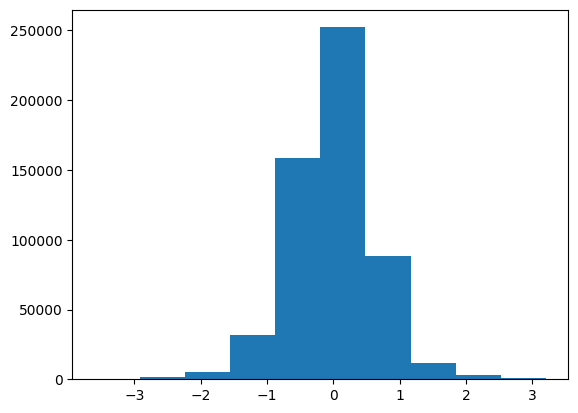

In [30]:
plt.hist(np.array(forces).flatten())

In [38]:
# R.shape

In [44]:
R = np.array([_.get_positions() for _ in test_traj])
Z = np.array([_.get_atomic_numbers() for _ in test_traj])
E = np.array(energies)
F = np.array(forces)
N = np.array([len(_.get_atomic_numbers()) for _ in test_traj])

In [47]:
xtb_data = {"R": R, "Z": Z, "E": E, "F": F, "N": N}
np.savez("xtb_data.npz", **xtb_data)

In [58]:
xtb_data["R"][0]

array([[ 0.86666866,  0.17891901,  1.52917131],
       [ 0.1577635 ,  0.49391329,  0.20751729],
       [-0.27519246, -0.64480223, -0.33668839],
       [-0.96017363, -0.44162413, -1.58297203],
       [ 0.01153121,  1.60207694, -0.27525758],
       [ 0.1402543 , -0.34460202,  2.18527302],
       [ 1.70283202, -0.51503722,  1.30431034],
       [-1.90311453,  0.13157246, -1.42897276],
       [-0.32087701,  0.11178952, -2.30923734],
       [-1.22164946, -1.42459951, -2.03429567],
       [ 1.40659554,  1.43891116,  2.24226903],
       [ 1.96092351,  1.15982837,  3.16403603],
       [ 2.09606326,  2.00078317,  1.57351596],
       [ 0.57166482,  2.11590827,  2.52430562],
       [ 8.90021104,  0.16111097,  1.51093158],
       [ 8.17798016,  0.49582342,  0.20124946],
       [ 7.77712724, -0.63976004, -0.37281211],
       [ 7.02196978, -0.41828009, -1.57873898],
       [ 7.9826106 ,  1.61303814, -0.23864918],
       [ 8.17928997, -0.3847751 ,  2.15413235],
       [ 9.74645451, -0.51541227,  1.272

In [48]:
np.load("xtb_data.npz")

NpzFile 'xtb_data.npz' with keys: R, Z, E, F, N

In [54]:
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.data import prepare_datasets
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets
from physnetjax.models.model import EF

NATOMS = 28
BATCH_SIZE = 8
DEFAULT_DATA_KEYS = ["Z", "R", "E", "F", "N"]
DATA_FILES = ["xtb_data.npz"]
CHECKPOINT_DIR = Path("/home/boittier/github/JaxPycharmm/ckpts/")

# restart = CHECKPOINT_DIR / "test-9392c2e7-af2a-4756-ae2a-35ffdf01951d"
# restart = None

# Initialize random keys
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

# Prepare datasets
train_data, valid_data = prepare_datasets(
    data_key,
    train_size=5000,
    valid_size=1000,
    files=DATA_FILES,
    natoms=NATOMS,
)

# Split validation data into validation and test sets
ntest = len(valid_data["E"]) // 2
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}

# Initialize model
model = EF(
    features=128,
    max_degree=0,
    num_iterations=3,
    num_basis_functions=16,
    cutoff=10.0,
    max_atomic_number=8,
    charges=False,
    efa=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=2,
    zbl=False,
)


dataR (6605, 28, 3)
dataE [-1130.82001892 -1130.82180535 -1130.82410438 -1130.82560702
 -1130.82769084 -1130.82976877 -1130.83053787 -1130.82643084
 -1130.8187957  -1130.81848082]
dataE [-1130.82001892 -1130.82180535 -1130.82410438 -1130.82560702
 -1130.82769084 -1130.82976877 -1130.83053787 -1130.82643084
 -1130.8187957  -1130.81848082]


In [ ]:
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    num_epochs=int(1e2),
    learning_rate=0.001,
    energy_weight=1,
    # charges_weight=1,
    # forces_weight=100,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=1,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    # restart=restart,
    print_freq=1,
    log_tb=False,
    name="cpen_mmml_test1",
    objective="valid_loss",
    best=1e6,
    batch_method="default",
)


In [56]:
restart = "/home/boittier/github/JaxPycharmm/ckpts/cpen_mmml_test1-1f4f68a8-27b3-4304-9b8d-a79b3e9c2785/"
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    num_epochs=int(500),
    learning_rate=0.001,
    energy_weight=1,
    # charges_weight=1,
    forces_weight=100,
    schedule_fn="constant",
    optimizer="amsgrad",
    batch_size=1,
    num_atoms=NATOMS,
    data_keys=DEFAULT_DATA_KEYS,
    restart=restart,
    print_freq=1,
    log_tb=False,
    name="cpen_mmml_test1",
    objective="valid_loss",
    best=1e6,
    batch_method="default",
)

                              Train Data                              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ (5000, 28, 3) │ (5000, 28) │ (5000, 28, 3) │ (5000, 1) │ (5000, 1) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┘

                         Validation Data                         
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ R            ┃ Z         ┃ F            ┃ E        ┃ N        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ (500, 28, 3) │ (500, 28) │ (500, 28, 3) │ (500, 1) │ (500, 1) │
└──────────────┴───────────┴──────────────┴──────────┴──────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /home/boittier/github/JaxPycharmm/data

LOGS_PATH: /home/boittier/github/JaxPycharmm/logs

ANALYSIS_PATH: /home/boittier/github/JaxPycharmm/analysis

MAIN_PATH: /home/boittier/github/JaxPycharmm

PYCHARMM_DIR: None

Start Time:  08:41:23

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ amsgrad   │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x15440cb4… │             │ 0x15440e48… │           │ 0x15440cb4… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x15440cb4… │             │             │           │ 0x15440cb4… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 1             │ 100           │ 27.21         │ 14.39          │ 1          │ 28        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                                    ┃ best      ┃ data_keys                 ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /home/boittier/github/JaxPycharmm/ckpts/cpen_mmml_test1-1… │ 1000000.0 │ ('Z', 'R', 'E', 'F', 'N') │ valid_loss │
└────────────────────────────────────────────────────────────┴───────────┴───────────────────────────┴────────────┘

                                            Validation Batch[0]                                            
┏━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Z     ┃ R       ┃ E      ┃ F       ┃ N    ┃ dst_idx ┃ src_idx ┃ batch_mask ┃ batch_segments ┃ atom_mask ┃
┡━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ (28,) │ (28, 3) │ (1, 1) │ (28, 3) │ (1,) │ (756,)  │ (756,)  │ (756,)     │ (28,)          │ (28,)     │
└───────┴─────────┴────────┴─────────┴──────┴─────────┴─────────┴────────────┴────────────────┴───────────┘

Extra Validation Info:
Z: Array[500, 28] i32 n=14000 (55Kb) x∈[1, 8] μ=3.429 σ=2.871 cpu:0
R: Array[500, 28, 3] n=42000 (0.2Mb) x∈[-3.690, 11.627] μ=1.325 σ=3.275 cpu:0
E: Array[500, 1] 2.0Kb x∈[-1.131e+03, -1.130e+03] μ=-1.131e+03 σ=0.101 cpu:0
N: Array[500, 1] i32 2.0Kb x∈[28, 28] μ=28.000 σ=0. cpu:0
F: Array[500, 28, 3] n=42000 (0.2Mb) x∈[-3.586, 3.205] μ=1.192e-10 σ=0.637 cpu:0


/home/boittier/mmml/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa  ┃ featu… ┃ max_a… ┃ max_de… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ True │ 128    │ 8      │ 0       │ 2     │ 28     │ 16     │ 3       │ 0      │ False │
└────────┴────────┴───────┴──────┴────────┴────────┴─────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/boittier/github/JaxPycharmm/ckpts/c… │ epoch-343 │ 343   │ Array gpu:0 0.117 │ 2025-06-26 10:17:10.750586 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /home/boittier/github/JaxPycharmm/ckpts/cpen_mmml_test1-1f4f68a8-27b3-4304-9b8d-a79b3e9c2785/epoch-343
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 343, best_loss Array gpu:0 0.117


                                                                       Model Attributes                                                                       
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa  ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━┩
│ 128      │ 0          │ 3              │ 16                  │ 10.0   │ 8                 │ False   │ 28     │ 0            │ 2     │ False │ False │ True │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴──────┘

Output()

KeyboardInterrupt: 

In [64]:
test_data

{'R': array([[[ 1.06219573e+00, -1.05527186e-02, -5.85233112e-01],
         [-2.65855055e-01,  6.99171960e-03,  1.58505642e-01],
         [-1.30046249e+00, -9.48518828e-03, -7.00359651e-01],
         ...,
         [ 5.68519905e+00, -1.76831260e+00,  2.24707251e+00],
         [ 7.41187118e+00, -1.42882532e+00,  2.48610153e+00],
         [ 9.99957325e+00,  6.27078118e-01, -1.25699021e+00]],
 
        [[ 4.38834149e-01,  1.11352102e+00, -9.01667437e-02],
         [-8.69665458e-02, -3.13848174e-01,  3.96065393e-02],
         [ 5.57253747e-01, -1.28387476e+00,  3.33544922e-01],
         ...,
         [ 1.05029990e+01,  6.76449114e-01,  5.33765381e-01],
         [ 1.03846847e+01,  2.13487761e-01, -1.20605407e+00],
         [ 5.49273523e+00,  6.48354383e-01,  9.03363867e-01]],
 
        [[ 4.38834149e-01,  1.11352102e+00, -9.01667437e-02],
         [-8.69665458e-02, -3.13848174e-01,  3.96065393e-02],
         [ 5.57253747e-01, -1.28387476e+00,  3.33544922e-01],
         ...,
         [ 5.8243

In [65]:
?prepare_batches

Signature:
prepare_batches(
    key,
    data: Dict[str, jax.Array],
    batch_size: int,
    data_keys: Optional[List[str]] = None,
    num_atoms: int = 60,
    dst_idx: Optional[jax.Array] = None,
    src_idx: Optional[jax.Array] = None,
    include_id: bool = False,
    debug_mode: bool = False,
) -> List[Dict[str, jax.Array]]
Docstring:
Efficiently prepare batches for training.

Args:
    key: JAX random key for shuffling.
    data (dict): Dictionary containing the dataset.
        Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
    batch_size (int): Size of each batch.
    data_keys (list, optional): List of keys to include in the output.
        If None, all keys in `data` are included.
    num_atoms (int, optional): Number of atoms per example. Default is 60.
    dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
    src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
    include_id (bool, optional)

In [71]:
test_batches = prepare_batches(data_key, test_data, batch_size=1, num_atoms=28,)

In [73]:
from physnetjax.analysis.analysis import eval



500it [08:42,  1.04s/it]


In [ ]:
res = eval(test_batches, model, params, batch_size=1)

In [75]:
res

(array([-1130.76072334, -1130.64152765, -1130.67391312, -1130.69735447,
        -1130.67425116, -1130.68955733, -1130.72824302, -1130.69038509,
        -1130.72182154, -1130.66094532, -1130.57798141, -1130.67798397,
        -1130.76264968, -1130.75677859, -1130.63281155, -1130.71363728,
        -1130.61402353, -1130.72880605, -1130.77222617, -1130.71363728,
        -1130.66958765, -1130.75016187, -1130.79211157, -1130.75502501,
        -1130.34827013, -1130.79344502, -1130.59730195, -1130.50226631,
        -1130.68923916, -1130.49128715, -1130.72849388, -1130.71881551,
        -1130.75202217, -1130.73096988, -1130.69479155, -1130.75824425,
        -1130.72075211, -1130.70899455, -1130.66150505, -1130.60945515,
        -1130.74500285, -1130.63763028, -1130.71824081, -1130.73274843,
        -1130.60582048, -1130.75207311, -1130.69950312, -1130.68555354,
        -1130.68538584, -1130.70613253, -1130.76211547, -1130.63555907,
        -1130.70642833, -1130.73192152, -1130.72031273, -1130.67

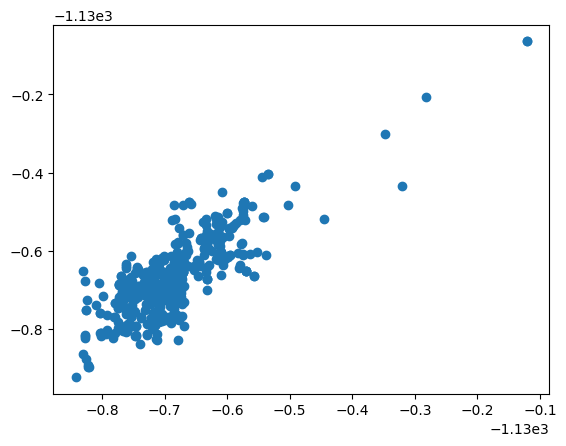

In [76]:
plt.scatter(res[0], res[2])

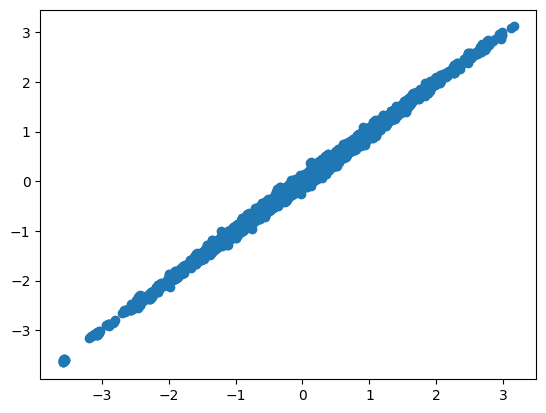

In [77]:
plt.scatter(res[3], res[4])

In [152]:
len(pycharmm.param.get_atc())

161

In [153]:
psf.get_iac()

[66,
 38,
 122,
 70,
 112,
 1,
 1,
 2,
 2,
 2,
 70,
 2,
 2,
 2,
 66,
 38,
 122,
 70,
 112,
 1,
 1,
 2,
 2,
 2,
 70,
 2,
 2,
 2]

In [154]:
[cgenff_params_dict_list[i][0] for i in psf.get_iac()]

[-0.031,
 -0.11,
 -0.1,
 -0.055,
 -0.2,
 -0.035,
 -0.035,
 -0.024,
 -0.024,
 -0.024,
 -0.055,
 -0.024,
 -0.024,
 -0.024,
 -0.031,
 -0.11,
 -0.1,
 -0.055,
 -0.2,
 -0.035,
 -0.035,
 -0.024,
 -0.024,
 -0.024,
 -0.055,
 -0.024,
 -0.024,
 -0.024]

In [92]:
len(psf.get_charges())

28

In [161]:
pycharmm_verbose()
energy.show()

  
 CHARMM>    WRNLev 5
  

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are      308 atom  pairs and      110 atom  exclusions.
 There are        0 group pairs and        2 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR      567 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
      308 ATOM PAIRS WERE FOUND FOR ATOM LIST
        0 GROUP PAIRS REQUIRED ATOM SEARCHES

 PRNHBD: CUToff Hydrogen Bond  distance =    0.5000   Angle =   90.0000
         CuT switching ON HB dist. =     3.5000  OFf HB dist. =    4.0000
         CuT switching ON Hb Angle =    50.0000  OFf Hb Angle =   70.0000
         ACCEptor antecedents included
         All hydrogen bond

# Calc

In [23]:
from mmml.pycharmmInterface.mmml_calculator import setup_calculator
from itertools import combinations, permutations, product
from typing import Dict, Tuple, List, Any, NamedTuple, Callable
import jax
from jax import Array

jaxphys_mmml_calc = setup_calculator(
     14,
      2,
    2.0,
     5.0,
     1.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = "/home/boittier/github/JaxPycharmm/ckpts/cpen_mmml_test1-1f4f68a8-27b3-4304-9b8d-a79b3e9c2785/",
    MAX_ATOMS_PER_SYSTEM = 45
)

0 1


/home/boittier/mmml/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa  ┃ featu… ┃ max_a… ┃ max_de… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ True │ 128    │ 8      │ 0       │ 2     │ 28     │ 16     │ 3       │ 0      │ False │
└────────┴────────┴───────┴──────┴────────┴────────┴─────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/boittier/github/JaxPycharmm/ckpts/c… │ epoch-463 │ 463   │ Array gpu:0 0.104 │ 2025-06-26 13:23:39.941233 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

In [24]:
setup_calculator?

Signature:
setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
    ep_scale=None,
    sig_scale=None,
    model_restart_path=None,
    MAX_ATOMS_PER_SYSTEM=100,
)
Docstring: <no docstring>
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [25]:
view_pycharmm_state()

In [26]:
atoms = ase_from_pycharmm_state()

In [27]:
len(atoms)

28

In [28]:
jaxphys_mmml_calc?

Signature:
jaxphys_mmml_calc(
    atomic_numbers: jax.Array,
    atomic_positions: jax.Array,
    n_monomers: int,
    cutoff_params: mmml.pycharmmInterface.mmml_calculator.CutoffParameters = None,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    backprop: bool = False,
    debug: bool = False,
) -> Tuple[mmml.pycharmmInterface.mmml_calculator.setup_calculator.<locals>.AseDimerCalculator, Callable]
Docstring: Factory function to create calculator instances
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [29]:
calc_test = jaxphys_mmml_calc(atoms.get_atomic_numbers(), atoms.get_positions(), 2, backprop=True, debug=True)

In [30]:
calc_test[0]?

Type:           AseDimerCalculator
String form:    <mmml.pycharmmInterface.mmml_calculator.setup_calculator.<locals>.AseDimerCalculator object at 0x150267615c40>
File:           ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Docstring:      ASE calculator implementation for dimer calculations
Init docstring: Initialize calculator with configuration parameters

In [31]:
atoms.calc = calc_test[0]

In [32]:
# dir(atoms.calc )

In [33]:
atoms.get_potential_energy()

ValueError: Incompatible shapes for broadcasting: (2, 5, 3) and requested shape (2, 14, 3)

In [ ]:
from mmml.pycharmmInterface.import_pycharmm import CGENFF_PRM, CGENFF_RTF
cgenff_params_dict = {}
cgenff_params_dict_list = []

for p in open(CGENFF_PRM).readlines():
    if len(p) > 5 and len(p.split()) > 4 and p.split()[1] == "0.0" and p[0] != "!":
        res, _, ep, sig = p.split()[:4]
        cgenff_params_dict[res] = (float(ep), float(sig))
        cgenff_params_dict_list.append((float(ep), float(sig)))
        

In [82]:
len(cgenff_params_dict.items())

161